# CNN, Activation Function, Batch Norm 과제
> 인공지능 스터디 다섯 번째 과제에 오신 것을 환영합니다! 강의를 들으면서 배운 다양한 지식들을 실습을 통해서 활용해볼 시간을 가질 것입니다!

### 필요한 라이브러리 설치

In [1]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision
import torch.nn as nn

**torch**는 PyTorch의 핵심 패키지로, 딥러닝 모델 구현에 필요한 기본 요소들을 포함하고있습니다.

**torch.nn**은 신경망 모델 구현에 필요한 다양한 층(Layer)과 함수들을 포함

**torchvision**은 Computer vision에서 사용하는 각종 테크닉들을 torch와 연동하여 구현한 라이브러리입니다. 

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [4]:
import numpy as np
import datetime
import os, sys

**numpy**는 행렬 연산을 위한 기본 수치 계산 라이브러리

**datetime**는 시간 기록용 라이브러리

**os**, **sys**는 운영체제 관련 정보 접근을 위한 라이브러리

**matplotlib**는 데이터 시각화 라이브러리

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'CNN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU가 있다면 GPU를 통해 학습을 가속화하고, 없으면 CPU로 학습하기 위해 device를 정해준다.

**torch.cuda.is_avaliable()** 는 GPU가 사용가능한지를 판단하는 함수

In [7]:
class MyCNN(nn.Module):
    """
        Simple CNN Clssifier
    """
    def __init__(self, num_classes=10):
        super(MyCNN, self).__init__()
        self.conv = nn.Sequential(
            # (N, 1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (N, 32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (N, 64, 7, 7)
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 512),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        y_ = self.conv(x) # (N, 64, 7, 7)
        y_ = y_.view(y_.size(0), -1) # (N, 64*7*7)
        y_ = self.fc(y_)
        return y_

### 모델 정의를 위한 코드

**nn.Module**: 뉴럴넷 구현을 위한 base class. forward, parameter 등 모델을 만들고 사용할 때 필요한 부분들이 내부적으로 구현되어 있음.

**__init__**: python class의 constructor. 필요한 멤버변수들을 초기화하고, **nn.Sequential** or **nn.ModuleList**를 이용하여 모델의 구성을 정의한다.

**forward**: 모델의 input을 받고 output을 return하는 함수.

**nn.Conv2d**: Convolutional Layer. 입력 채널과 출력 채널을 parameter로 받는다. kernel size가 3이므로 padding 1을 통해 같은 크기가 나오도록 한다.

**nn.MaxPool2d**: max pooling을 수행한다. feature map size를 줄여주는 역할.

**nn.Dropout**: Dropout. p는 drop probability

### **사전지식**

nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=1)의 주요 인자들:

in_channels: 입력 채널 수
out_channels: 출력 채널 수
kernel_size: 컨볼루션 필터의 크기
stride: 필터가 이동하는 간격
padding: 입력 데이터 주변을 특정 값으로 채우는 크기

#### ❓ <font color='red'><b>[ 퀴즈 ]</b></font> 커널 사이즈 이해하기
다음 상황에서 출력 feature map의 크기를 계산해보세요.

입력 이미지 크기: 28x28

커널 사이즈: 5x5

stride: 1

padding: 0

#### ! <font color='green'><b>[ 정답 ]</b></font> 작성해주세요
? 24x24

#### ❓ <font color='red'><b>[ 퀴즈 ]</b></font> ReLU의 역할
ReLU의 역할을 설명해주세요

#### ! <font color='green'><b>[ 정답 ]</b></font> 작성해주세요
? 입력값(x)이 양수면 자기 자신(x)을 반환하고, 음수면 0을 반환하는 함수. 기존 sigmoid 함수에서 발생한 기울기 소실 문제를 해결하기 위한 대책으로 쓰이는 활성화 함수이다.

#### ❓ <font color='red'><b>[ 퀴즈 ]</b></font> MaxPooling 계산

MaxPool2d(2, 2)를 적용할 때, 다음 feature map의 크기 변화를 계산해보세요:
입력 feature map: 14x14

#### ! <font color='green'><b>[ 정답 ]</b></font> 작성해주세요
? 7x7

In [8]:
model = MyCNN().to(DEVICE)

정의한 모델을 메모리에 올리는 작업.

## 데이터 전처리
### 데이터 변환

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),]
)

#### ❓ <font color='red'><b>[ 생각해보기 ]</b></font> 정규화

입력 정규화가 왜 필요할까요?

hint : transforms.Normalize((0.1307,), (0.3081,))는 MNIST 데이터셋의 평균(mean)과 표준편차(standard deviation)를 사용한 정규화입니다.

## 데이터셋 로드


In [10]:
mnist_train = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data/', train=False, transform=transform, download=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 9912422/9912422 [00:03<00:00, 2995545.65it/s]


Extracting ../data/MNIST\raw\train-images-idx3-ubyte.gz to ../data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 28881/28881 [00:00<00:00, 166544.57it/s]


Extracting ../data/MNIST\raw\train-labels-idx1-ubyte.gz to ../data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1463435.11it/s]


Extracting ../data/MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 4542/4542 [00:00<00:00, 4521844.00it/s]

Extracting ../data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/MNIST\raw



In [11]:
print(mnist_train.data)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [12]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

**datasets**에는 여러 데이터들에 대해 다운로드하고 처리하는 클래스가 내장되어 있음. [참고](https://pytorch.org/docs/stable/torchvision/datasets.html)

root 폴더에 없을 시에 download하고, 앞서 정의한 transform에 따라 전처리 된 데이터를 return함.

In [13]:
batch_size = 64

## 데이터 로더 설정

In [14]:
train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=mnist_test, batch_size=100, shuffle=False, drop_last=False)

**DataLoader**는 pytorch에서 학습 시에 데이터를 배치 사이즈만큼씩 효율적으로 불러오도록 돕는 클래스. 잘 사용할수록 GPU의 사용률이 올라간다.

**shuffle**: every epochs 마다 데이터의 순서를 랜덤하게 섞는다.

**drop_last**: 데이터의 개수가 배치 사이즈로 나눠떨어지지 않는 경우, 마지막 배치를 버린다. 주로 학습시에만 사용.

In [15]:
criterion = nn.CrossEntropyLoss() # 손실 함수 (내부적으로 softmax 포함)
optim = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

**nn.CrossEntropyLoss**: Cross entropy를 계산하는 Loss. softmax가 내부적으로 수행된다.

**optim.Adam**: optim에는 여러 optimizer가 있고, Adam Optimizer는 대표적으로 많이 사용된다.

## 최대 epoch 조정

In [16]:
max_epoch = 5
step = 0

### Training

첫번째 for문 - 원하는 epoch만큼 반복

두번째 for문 - training datset에서 배치 사이즈 만큼씩 모두 샘플링 될 때까지 반복.

**Line 2**: MNIST dataset은 DataLoader를 통해 image와 label을 return.

**Line 4**: 각각 Device에 올린다 (GPU or CPU)

**Line 5**: 모델에 이미지를 넣고 forward propagation 한다.

**Line 7**: 결과값 y_hat과 실제 정답 y에 대한 loss를 계산한다.

**zero_grad (Line 9)**: 모델의 gradient를 0으로 초기화한다.

**backward (Line 10)**: loss를 계산하는 것까지 연결되어있는 graph를 따라 gradient를 계산한다.

**step (Line 11)**: 계산된 gradient를 모두 parameter에 적용한다.

**eval (Line 17)**: 모델을 evaluation mode로 바꿔준다 (dropout 조정, Batch normalization 조정 등)

**torch.no_grad (Line 19)**: 그래디언트 계산 비활성화

**torch.max (Line 24)**: max value와 indices(즉, argmax)를 return.

**train (Line 29)**: evaluation mode였던 모델을 train mode로 전환

In [17]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(train_loader):
        # Training Discriminator
        x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
        y_hat = model(x) # (N, 10)
        
        loss = criterion(y_hat, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, Loss: {}'.format(epoch, max_epoch, step, loss.item()))
        
        if step % 1000 == 0:
            model.eval()
            acc = 0.
            with torch.no_grad():
                for idx, (images, labels) in enumerate(test_loader):
                    x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
                    y_hat = model(x) # (N, 10)
                    loss = criterion(y_hat, y)
                    _, indices = torch.max(y_hat, dim=-1)
                    acc += torch.sum(indices == y).item()
            print('*'*20, 'Test', '*'*20)
            print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), acc/len(mnist_test)*100))
            print('*'*46)
            model.train()
        step += 1

Epoch: 0/5, Step: 0, Loss: 2.3281126022338867
******************** Test ********************
Step: 0, Loss: 2.7465667724609375, Accuracy: 16.8 %
**********************************************
Epoch: 0/5, Step: 500, Loss: 0.042913950979709625
Epoch: 1/5, Step: 1000, Loss: 0.006804842036217451
******************** Test ********************
Step: 1000, Loss: 0.02018159069120884, Accuracy: 98.49 %
**********************************************
Epoch: 1/5, Step: 1500, Loss: 0.028603332117199898
Epoch: 2/5, Step: 2000, Loss: 0.011636667884886265
******************** Test ********************
Step: 2000, Loss: 0.043180789798498154, Accuracy: 98.77 %
**********************************************
Epoch: 2/5, Step: 2500, Loss: 0.005013304762542248
Epoch: 3/5, Step: 3000, Loss: 0.10214578360319138
******************** Test ********************
Step: 3000, Loss: 0.011012118309736252, Accuracy: 98.97 %
**********************************************
Epoch: 3/5, Step: 3500, Loss: 0.00705323182046413

#### ❓ <font color='red'><b>[ 퀴즈 ]</b></font> zero_grad()와 no_grad()의 차이

optim.zero_grad()와 torch.no_grad()의 차이를 생각해보면서 이 코드에서는 어떤 주기로 평가되는지 서술하시오

#### ! <font color='green'><b>[ 정답 ]</b></font> 작성해주세요

? loss.backward()를 통해 gradient가 역전파로 계산되어 누적된다. optim.zero_grad()는 각 step마다 gradient를 0으로 초기화해줘서 이전 step의 gradient가 다음 step에 영향을 주지 않도록 한다. <br>
한편 torch.no_grad()는 모델 평가 단계에서 gradient 계산을 비활성화하여 메모리 효율성을 높인다. <br>
이 코드에선 `step % 1000 == 0` 조건에 따라 모델의 평가가 수행된다.

## Test and Visualize

학습시킨 모델이 얼만큼의 성능을 가지는지 테스트해봅시다.

In [18]:
# Test
model.eval()
acc = 0.
with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
        y_hat = model(x) # (N, 10)
        loss = criterion(y_hat, y)
        _, indices = torch.max(y_hat, dim=-1)
        acc += torch.sum(indices == y).item()
print('*'*20, 'Test', '*'*20)
print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), acc/len(mnist_test)*100))
print('*'*46)

******************** Test ********************
Step: 4685, Loss: 0.011253447271883488, Accuracy: 99.06 %
**********************************************


7777번째 사진의 차원과, 정답값을 확인해봅시다.

In [19]:
idx = 7777 # 0 to 9999
img, y = mnist_test[idx]
img.shape, y

(torch.Size([1, 28, 28]), 5)

어떻게 생겼는지도 궁금하군요. 확인해볼까요?

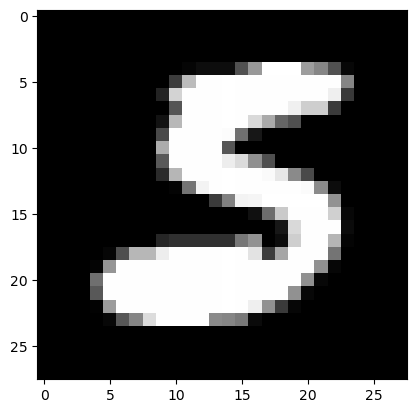

In [20]:
imshow(img[0], cmap='gray')

In [21]:
img = img.unsqueeze(dim=0)

**unsqueeze**: 원하는 dim에 차원을 높여준다. 단일 이미지를 배치 형태로 변환 (N, C, H, W)해주는 과정으로 CNN forward를 위해서는 4D-Tensor여야합니다. 우리가 이제껏 봤던 RGB 이미지 데이터셋은 3차원이지만, 데이터의 개수를 고려해주는 N으로 한번 더 넓혔다고 생각해볼 수 있겠고요, 현재는 mnist gray scale dataset이므로 흑백차원이므로 C가 Grayscale: 1채널이라고 생각하면 될 것 같습니다. 

우리가 학습시켰던 모델에 sample을 넣어봅시다.

In [22]:
sample = img.to(DEVICE)
out = model(sample)

out값을 확인해볼까요?

In [23]:
print(out)

tensor([[ -8.6256,  -3.8690, -10.0080,   8.8356,  -8.7642,  21.2227,  -2.7468,
          -9.2686,   2.3063,   2.8462]], grad_fn=<AddmmBackward0>)


가장 큰 값이 무엇일까요?

In [24]:
_, idx = out.max(dim=-1)
idx

tensor([5])

우리가 학습시켰던 가중치를 pkl로 저장하면서 마무리해봅시다.

In [25]:
# Saving params.
torch.save(model.state_dict(), 'model.pkl')

음. 그런데 끝내기 전에 우리가 5주차에 배웠던 내용을 생각해보면 뭔가 언급이 안되었던 부분이 있었던 것 같은데요?
정의된 MyCNN을 볼까요?

In [26]:
class MyCNN(nn.Module):
    """
        Simple CNN Clssifier
    """
    def __init__(self, num_classes=10):
        super(MyCNN, self).__init__()
        self.conv = nn.Sequential(
            # (N, 1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (N, 32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (N, 64, 7, 7)
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 512),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        y_ = self.conv(x) # (N, 64, 7, 7)
        y_ = y_.view(y_.size(0), -1) # (N, 64*7*7)
        y_ = self.fc(y_)
        return y_

뭐가 빠졌죠?

음..


.


.


.


🤔

.


.


.


.


🤔

.


.


.


.


🤔

.


.


.


.


🤔

아!




# 맞습니다. BatchNorm이 없네요?
이 CNN 모델에 BatchNorm이 포함되지 않은 것은 의도적인 선택으로 보이는데요, BatchNorm을 써야하는 상황은

### 1. 깊은 신경망 구조

레이어가 많은 심층 네트워크
Internal Covariate Shift 문제 해결 필요


### 2. 불안정한 학습 과정

학습이 불안정하거나 수렴이 느린 경우
그래디언트 소실/폭발 문제 발생 시


### 3. 큰 배치 사이즈

배치 사이즈가 충분히 클 때 효과적
일반적으로 32 이상 권장


### 4. 높은 학습률 필요

빠른 학습을 위해 높은 learning rate 사용 시
학습 안정성 확보 필요

으로 정리할 수 있을 것 같습니다. 

이 MNIST 예제의 경우 간단한 구조와 데이터셋 특성상 BatchNorm 없이도 충분히 학습 가능합니다.

하지만 코드를 안보고 넘어가면 아쉬우니까 다음 코드에다 BatchNorm을 추가해서 수정해주세요.

In [27]:
class MyCNN(nn.Module):
    """
        Simple CNN Clssifier
    """
    def __init__(self, num_classes=10):
        super(MyCNN, self).__init__()
        self.conv = nn.Sequential(
            # (N, 1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (N, 32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            # (N, 64, 7, 7)
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 512),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        y_ = self.conv(x) # (N, 64, 7, 7)
        y_ = y_.view(y_.size(0), -1) # (N, 64*7*7)
        y_ = self.fc(y_)
        return y_

이번주에 Low-Rank Adaptation (LoRA)도 학습해봤는데요, 관심있으신 분들은 난이도에 맞게 아래 자료도 읽어보시면 좋을 것 같아요!

### 음.. 난 아직 논문까지는 어려워.. 😕😕
**Easy Mode** : 논문 리뷰 읽기 [https://kimjy99.github.io/%EB%85%BC%EB%AC%B8%EB%A6%AC%EB%B7%B0/lora/]

### 한번 읽어볼까? 얼마나 어렵겠어? 😎😎

Hard Mode : 논문 원본 읽기 [https://arxiv.org/abs/2106.09685]

### 🎉🎉🎉 5주차 과제 완료! 🎉🎉🎉
```python
🐙
여러분 모두 수고 했어요!! 이번주 과제를 complete한 당신에게 행운을 드립니다. 
```